## Example: Autoregressive model

In this example we are going to perform an automated Variational Bayesian Inference for autoregressive model that can be represented as following:

$$
\begin{equation}
\begin{aligned}
p(\gamma) &= \mathrm{Gamma}(\gamma|a, b),\\
p(\mathbf{\theta}) &= \mathcal{N}(\mathbf{\theta}|\mathbf{\mu}, \Sigma),\\
p(x_t|\mathbf{x}_{t-1:t-k}) &= \mathcal{N}(x_t|\mathbf{\theta}^{T}\mathbf{x}_{t-1:t-k}, \gamma^{-1}),\\
p(y_t|x_t) &= \mathcal{N}(y_t|x_t, \tau^{-1}),
\end{aligned}
\end{equation}
$$

where $x_t$ is a current state of our system, $\mathbf{x}_{t-1:t-k}$ is a sequence of $k$ previous states, $k$ is an order of autoregression process, $\mathbf{\theta}$ is a vector of transition coefficients, $\gamma$ is a precision of state transition process, $y_k$ is a noisy observation of $x_k$ with precision $\tau$.

For a more rigorous introduction to Bayesian inference in Autoregressive models we refer to [Albert Podusenko, Message Passing-Based Inference for Time-Varying Autoregressive Models](https://www.mdpi.com/1099-4300/23/6/683).

We start with importing all needed packages:

In [382]:
using Rocket, ReactiveMP, GraphPPL
using Distributions, LinearAlgebra, Random, Plots

Lets generate some synthetic dataset, we use a predefined sets of coeffcients for $k$ = 1, 3 and 5 respectively:

In [385]:
# The following coefficients correspond to stable poles
coefs_ar_1 = [-0.27002517200218096]
coefs_ar_2 = [0.4511170798064709, -0.05740081602446657]
coefs_ar_5 = [0.10699399235785655, -0.5237303489793305, 0.3068897071844715, -0.17232255282458891, 0.13323964347539288];

In [434]:
function generate_ar_data(rng, n, θ, γ, τ)
    order        = length(θ)
    states       = Vector{Vector{Float64}}(undef, n + 3order)
    observations = Vector{Float64}(undef, n + 3order)
    
    γ_std = sqrt(inv(γ))
    τ_std = sqrt(inv(γ))
    
    states[1] = randn(rng, order)
    
    for i in 2:(n + 3order)
        states[i]       = vcat(rand(rng, Normal(dot(θ, states[i - 1]), γ_std)), states[i-1][1:end-1])
        observations[i] = rand(rng, Normal(states[i][1], τ_std))
    end
    
    return states[1+3order:end], observations[1+3order:end]
end

generate_ar_data (generic function with 3 methods)

In [569]:
# Seed for reproducibility
seed = 123
rng  = MersenneTwister(seed)

# Number of observations in synthetic dataset
n = 450

# AR process parameters
real_γ = 5.0
real_τ = 5.0
real_θ = coefs_ar_5

states, observations = generate_ar_data(rng, n, real_θ, real_γ, real_τ);

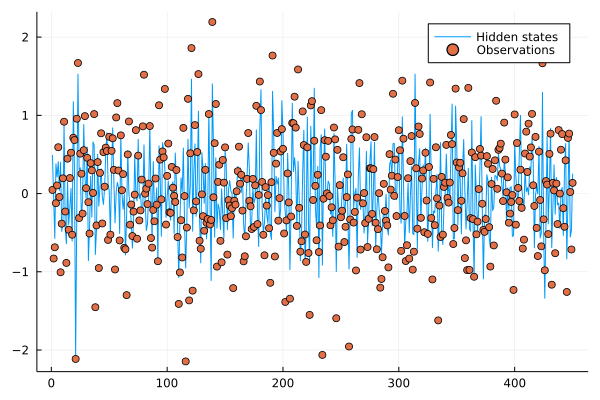

In [570]:
plot(first.(x), label = "Hidden states")
scatter!(y, label = "Observations")

We use `GraphPPL.jl` package to specify probabilistic model and additional constraints for variational Bayesian Inference:

In [571]:
@model [ default_factorisation = MeanField() ] function lar_model(T::Type{ Multivariate }, n, order, c, stype, τ)
    
    # Parameter priors 
    γ  ~ GammaShapeRate(1.0, 1.0) 
    θ  ~ MvNormalMeanPrecision(zeros(order), diageye(order))
    
    # We create a sequence of random variables for hidden states
    x = randomvar(n)
    # As well a sequence of observartions
    y = datavar(Float64, n)
    
    ct = constvar(c)
    # We assume observation noise to be known
    cτ = constvar(τ)
    
    # Prior for first state
    x0 ~ MvNormalMeanPrecision(zeros(order), diageye(order))
    
    x_prev = x0
    
    # AR process requires extra meta information
    meta = ARMeta(Multivariate, order, stype)
    
    for i in 1:n
        # Autoregressive node uses structured factorisation assumption between states
        x[i] ~ AR(x_prev, θ, γ) where { q = q(y, x)q(γ)q(θ), meta = meta }
        y[i] ~ NormalMeanPrecision(dot(ct, x[i]), cτ)
        x_prev = x[i]
    end
    
    return x, y, θ, γ
end

lar_model (generic function with 4 methods)

In [572]:
@model [ default_factorisation = MeanField() ] function lar_model(T::Type{Univariate}, n, order, c, stype, τ)
    
    # Parameter priors 
    γ  ~ GammaShapeRate(1.0, 1.0)
    θ  ~ NormalMeanPrecision(0.0, 1.0)
    
    # We create a sequence of random variables for hidden states
    x = randomvar(n)
    # As well a sequence of observartions
    y = datavar(Float64, n)
    
    ct = constvar(c)
    # We assume observation noise to be known
    cτ = constvar(τ) 

    # Prior for first state
    x0 ~ NormalMeanPrecision(0.0, 1.0)
    
    x_prev = x0
    
    # AR process requires extra meta information
    meta = ARMeta(Univariate, order, stype)
    
    for i in 1:n
        x[i] ~ AR(x_prev, θ, γ) where { q = q(y, x)q(γ)q(θ), meta = meta }
        y[i] ~ NormalMeanPrecision(ct * x[i], cτ)
        x_prev = x[i]
    end
    
    return x, y, θ, γ
end

lar_model (generic function with 4 methods)

In [573]:
function init_marginals!(::Type{ Multivariate }, order, γ, θ)
    setmarginal!(γ, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(order), diageye(order)))
end

function init_marginals!(::Type{ Univariate }, order, γ, θ)
    setmarginal!(γ, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, NormalMeanPrecision(0.0, 1.0))
end

init_marginals! (generic function with 4 methods)

In [574]:
function inference(data, order, artype, stype, niter, τ)
    
    # We build a full graph based on nber of observatios
    n = length(data)
    
    # Depending on the order of AR process `c` is
    # either a nber or a vector
    c = ReactiveMP.ar_unit(artype, order)
    
    model, (x, y, θ, γ) = lar_model(artype, n, order, c, stype, τ)
    
    # We are going to keep `γ` and `θ` estimates for all VMP iterations
    # But `buffer` only last posterior estimates for a sequence of hidden states `x`
    γ_buffer = keep(Marginal)
    θ_buffer = keep(Marginal)
    x_buffer = buffer(Marginal, n)
    
    fe = keep(Float64)
    
    γsub  = subscribe!(getmarginal(γ), γ_buffer)
    θsub  = subscribe!(getmarginal(θ), θ_buffer)
    xsub  = subscribe!(getmarginals(x), x_buffer)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)
    
    init_marginals!(artype, order, γ, θ)
    
    for i in 1:niter
        update!(y, data)
    end
    
    unsubscribe!((γsub, θsub, xsub, fesub))
    
    return γ_buffer, θ_buffer, x_buffer, fe
end

inference (generic function with 2 methods)

In [602]:
γ, θ, xs, fe = inference(observations, length(real_θ), Multivariate, ARsafe(), 15, τ);

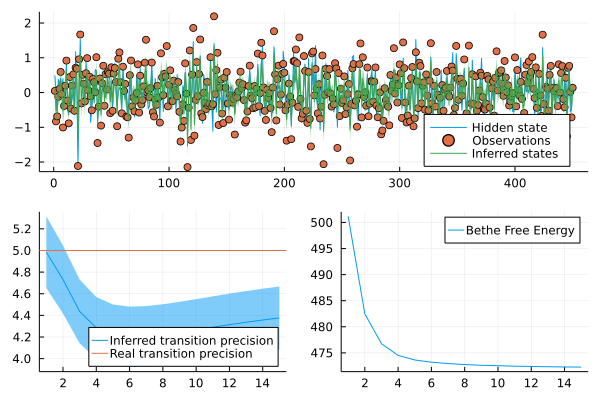

In [603]:
p1 = plot(first.(states), label="Hidden state")
p1 = scatter!(p1, observations, label="Observations")
p1 = plot!(p1, first.(mean.(xs)), ribbon = sqrt.(first.(var.(xs))), label="Inferred states", legend = :bottomright)

p2 = plot(mean.(γ), ribbon = std.(γ), label = "Inferred transition precision", legend = :bottomright)
p2 = plot!([ real_γ ], seriestype = :hline, label = "Real transition precision")

p3 = plot(getvalues(fe), label = "Bethe Free Energy")

plot(p1, p2, p3, layout = @layout([ a; b c ]))

Lets also plot a subrange of our results:

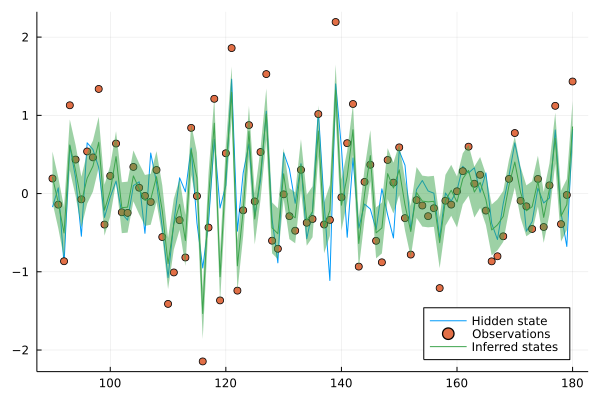

In [604]:
subrange = div(n,5):(div(n, 5) + div(n, 5))

plot(subrange, first.(states)[subrange], label="Hidden state")
scatter!(subrange, observations[subrange], label="Observations")
plot!(subrange, first.(mean.(xs))[subrange], ribbon = sqrt.(first.(var.(xs)))[subrange], label="Inferred states", legend = :bottomright)

We can also run a different AR order process for inference from data generation process. Lets try to run a 1-order AR inference on 5-order AR data:

In [605]:
println("$(length(real_θ))-order AR inference Bethe Free Energy: ", last(fe))

5-order AR inference Bethe Free Energy: 472.2755092497773


In [606]:
γ, θ, xs, fe = inference(observations, 1, Univariate, ARsafe(), 15, real_τ);

In [607]:
println("1-order AR inference Bethe Free Energy: ", last(fe))

1-order AR inference Bethe Free Energy: 477.9527158481423


We can see that in this example 5-order AR process according to final Bethe Free Energy value can describe data better than 1-order AR. Note however, that it is not always the case for AR process.

We may be also interested in benchmarking our algorithm:

In [608]:
println("Benchmark for n = $n and AR-$(length(real_θ)) inference");
@benchmark inference($observations, length(real_θ), Multivariate, ARsafe(), 15, real_τ)

Benchmark for n = 450 and AR-5 inference


BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  714.164 ms … 823.216 ms  ┊ GC (min … max): 17.36% … 13.61%
 Time  (median):     740.296 ms               ┊ GC (median):    16.74%
 Time  (mean ± σ):   746.408 ms ±  38.528 ms  ┊ GC (mean ± σ):  16.41% ±  2.26%

  ▁▁  ▁         █              ▁                              ▁  
  ██▁▁█▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  714 ms           Histogram: frequency by time          823 ms <

 Memory estimate: 409.02 MiB, allocs estimate: 3201970.